# Weakly-supervised Semantic Segmentation

In [1]:
import sys
import os
sys.path.append("../") 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
from config import (IMAGE_DATA_DIR, TILES_DIR, 
                    LABELS, RED, BLACK, N1, N2, N_validation, CODES, 
                    BASE_DIR, MODEL_DIR
                   )
from loss_custom import WeakCrossEntropy
from metrics_custom import acc_weakly, acc_satellite
from parameters import IMG_SIZE_RATIO
from util import (set_seed, is_in_set_n1_or_nvalidation, is_in_set_nvalidation, 
                  REGEX_IMG_FILE_NAME_WITH_LABEL_VECTOR, is_in_set_n2_or_nvalidation, 
                  get_y_colors, has_a_valid_color, show_prediction_vs_actual
                 )
set_seed(seed=42)
free = gpu_mem_get_free_no_cache(); free

0

In [5]:
image_tiles_fnames = os.listdir(BASE_DIR / TILES_DIR)

In [6]:
fname = image_tiles_fnames[0]; fname

'top_mosaic_09cm_area2_tile5_11110.tif'

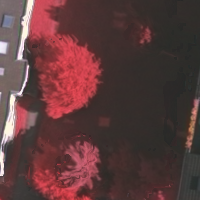

In [7]:
img = open_image(BASE_DIR / TILES_DIR / fname)
img

### Load data

In [8]:
codes = LABELS
# codes = LABELS+[RED, BLACK]

src_size = np.array(img.shape[1:])
size = (src_size * IMG_SIZE_RATIO).astype(int)

item_list = (ImageList.from_folder(BASE_DIR / TILES_DIR)
             .filter_by_func(partial(is_in_set_n2_or_nvalidation, regex_obj=REGEX_IMG_FILE_NAME_WITH_LABEL_VECTOR))
             .filter_by_func(has_a_valid_color)
             .split_by_valid_func(partial(is_in_set_nvalidation, regex_obj=REGEX_IMG_FILE_NAME_WITH_LABEL_VECTOR))
             .label_from_func(get_y_colors, classes=codes)
             .transform(get_transforms(), size=size)
            )

In [9]:
item_list

LabelLists;

Train: LabelList (3171 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: MultiCategoryList
(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0),(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0)
Path: /Users/markus/Development/weakly_superv_learning/data/ISPRS_semantic_labeling_Vaihingen/top_weaklabel_tiles;

Valid: LabelList (935 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: MultiCategoryList
(255, 255, 255);(0, 0, 255),(255, 255, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0);(255, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0);(255, 255, 0),(255, 255, 255);(0, 255, 255);(255, 255, 0)
Path: /Users/markus/Development/weakly_superv_learni

In [10]:
# DEBUG
item_list.train.y[0]

MultiCategory [1. 1. 1. 1. 0.]

In [11]:
# item_list.train.items[0]
item_list.train.c

5

In [12]:
bs = 64
data = item_list.databunch(bs=bs).normalize(imagenet_stats)
data.c = 5

In [13]:
data.classes[:10], len(data.classes)

([(255, 255, 255), (0, 0, 255), (0, 255, 255), (0, 255, 0), (255, 255, 0)], 5)

In [14]:
data

ImageDataBunch;

Train: LabelList (3171 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: MultiCategoryList
(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0),(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0)
Path: /Users/markus/Development/weakly_superv_learning/data/ISPRS_semantic_labeling_Vaihingen/top_weaklabel_tiles;

Valid: LabelList (935 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: MultiCategoryList
(255, 255, 255);(0, 0, 255),(255, 255, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0);(255, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0);(255, 255, 0),(255, 255, 255);(0, 255, 255);(255, 255, 0)
Path: /Users/markus/Development/weakly_superv_le

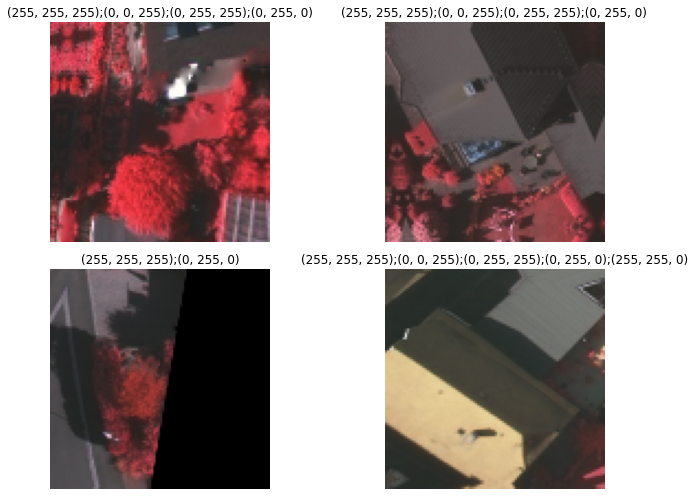

In [15]:
data.show_batch(2, figsize=(10,7))

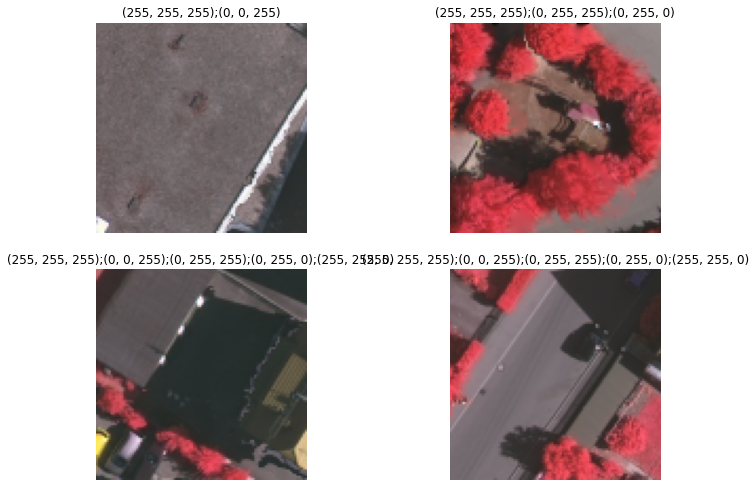

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [17]:
# item_list

# all tiles: 4497
# 935 / 4497 = 20%
# 390 / 4497 = 8.6%

# This seems to be the desired split

## Model

Train and compare semantic segmentation networks, using the following data: Task (i) N1 pixel level labels

In [18]:
# wd=0.1 # TODO
wd=0.01

In [19]:
learn = unet_learner(data, 
                     models.resnet18, 
                     loss_func=WeakCrossEntropy(CODES, axis=1),
                     metrics=[acc_weakly], 
                     wd=wd,
                     model_dir=MODEL_DIR
                    )

In [20]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(1, slice(lr), pct_start=0.9)

In [ ]:
learn.recorder.plot_losses(skip_start=50, show_grid=True)
learn.recorder.plot_metrics(skip_start=50, show_grid=True)

In [ ]:
learn.save('ws-stage-1')

In [21]:
learn.load('ws-stage-1');

## Show Results

Here we show the original image and the predicted mask. (The correct mask is not part of the N2 dataset and was therefore not loaded and is not shown here).

MultiCategory [1. 1. 0. 0. 0.]


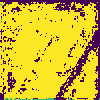

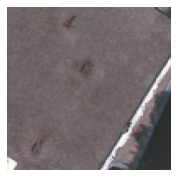

In [22]:
show_prediction_vs_actual(0, learn)

MultiCategory [1. 0. 1. 1. 0.]


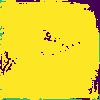

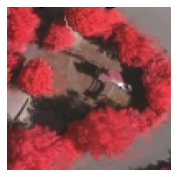

In [23]:
show_prediction_vs_actual(1, learn)

MultiCategory [1. 1. 1. 1. 1.]


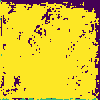

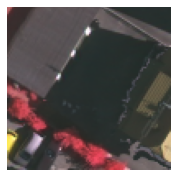

In [24]:
show_prediction_vs_actual(2, learn)

MultiCategory [1. 1. 1. 1. 1.]


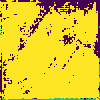

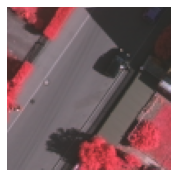

In [25]:
show_prediction_vs_actual(3, learn)

MultiCategory [1. 0. 1. 0. 1.]


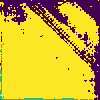

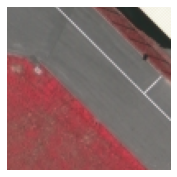

In [26]:
show_prediction_vs_actual(4, learn)

## Calculate acc_satellite